# Protein-ligand binding process analysis with MSM

In this tutorial, we demonstrate how to use the HTMD code for analysing a protein-ligand binding process.

To analyze, one needs MD trajectories first, which can be generated with HTMD. Here, we already provide the trajectories (data) to analyze. You can download the data from [here](http://pub.htmd.org/tutorials/ligand-binding-analysis/datasets.tar.gz). (**Warning: 3GB filesize**)

Alternatively, you can download the dataset using `wget`.

In [ ]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/ligand-binding-analysis/ligand_binding_datasets/') == 0

## Getting started

First we import the modules we are going to need for the tutorial:

In [1]:
from htmd.ui import *
from moleculekit.config import config

config(viewer='webgl')

2024-06-12 10:33:26,925 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-12 10:33:26,926 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-06-12 10:33:27,044 - rdkit - INFO - Enabling RDKit 2022.09.1 jupyter extensions



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049
HTMD Documentation at: https://software.acellera.com/htmd/

You are on the latest HTMD version (2.3.28+8.g0ec8f27eb.dirty).



## Creating a simulation list

For the purposes of an analysis, full atom information is required by HTMD. Therefore each simulation trajectory has to be associated with a corresponding PDB file. Additionally, if you plan to run adaptive, each trajectory needs to be associated with an input directory which contains the files used to run the simulations. The `simlist` function allows us to make these associations

```python
sims = simlist(glob('data/*/'), glob('input/*/structure.pdb'), glob('input/*/'))
```

## Filtering trajectories

Typically waters are removed from the trajectories as they are not used in the analysis and it helps speed up further calculations. These filtered trajectories are written into a new directory. The advantage of filtering is that if your input structures only differ in the number of water molecules, you can produce a single unique pdb file for all simulations once you remove the waters, which will speed up calculations. This step is not necessary for the analysis and you can skip it if you don't mind the slowdown in calculations. In that case replace in the following commands the fsims variable with sims.
```python
fsims = simfilter(sims, './filtered/', filtersel='not water')
```

In this tutorial, in order for the trajectories to be downloaded in a timely manner, we provide only the filtered trajectories, which are stored in three separate dataset folders. Therefore we will skip the above two commands and construct the simulation list directly from the filtered trajectories:

In [2]:
sets = glob('ligand_binding_datasets/*/')
sims = []
for s in sets:
    fsims = simlist(glob(s + '/filtered/*/'), 'ligand_binding_datasets/1/filtered/')
    sims = simmerge(sims, fsims)

Creating simlist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:01<00:00, 213.17it/s]


## Calculating metrics

To build a Markov state model we need to project the atom coordinates onto a lower dimensional space which can be used for clustering the conformations into a set of states. For protein systems we typically use the binary contact map between the carbon alpha atoms of the protein. This will calculate contacts between all carbon-alpha atoms. 

In [3]:
metr = Metric(sims)
metr.set(MetricDistance('protein and name CA', 'resname MOL and noh', periodic='selections', metric='contacts'))
data = metr.project()

Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 852/852 [00:48<00:00, 17.45it/s]
2024-06-12 10:34:21,795 - htmd.projections.metric - INFO - Frame step 0.001ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


Here, we also provide the frame-step in nanoseconds i.e. the time that passes between two consecutive frames in a trajectory. This should be automatically read from the trajectories, but some simulation software does not contain the correct fstep in the trajectories, so it can be useful to manually define it:

In [4]:
data.fstep = 0.1

## Removing trajectories

Sometimes the set of trajectories can contain trajectories of incorrect length. These are typically corrupted trajectories and are removed.

The `plotTrajSizes` method plots all trajectory lengths, sorted:

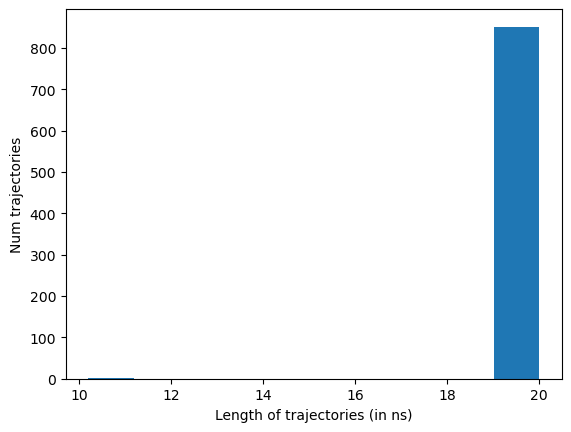

In [5]:
data.plotTrajSizes()

The `dropTraj` method has multiple options for removing simulations from the dataset. Here, we use it to remove all trajectories whose length is not equal to the mode length:

In [6]:
data.dropTraj()

2024-06-12 10:34:22,123 - htmd.metricdata - INFO - Dropped 2 trajectories from 852 resulting in 850


array([496, 562])

## TICA

TICA is a method that can be used to improve the clustering of the conformations. This is done by projecting the data onto a lower-dimensional space which separates well the metastable minima and places clusters on the transition regions. 

In [ ]:
tica = TICA(data, 2, units='ns')
dataTica = tica.project(3)

## Bootstrapping

If we want to bootstrap our calculations we can at this point drop a random 20% of the trajectories and do the rest of the analysis multiple times to see if the results are consistent. Alternatively we can keep on using dataTica in the following commands. 

In [ ]:
dataBoot = dataTica.bootstrap(0.8)

## Clustering conformations

Once we have cleaned the dataset we proceed to cluster the conformations.

Here we use the mini-batch kmeans clustering algorithm to produce 1000 clusters.

In [ ]:
dataBoot.cluster(MiniBatchKMeans(n_clusters=1000))

## Building the Markov model

After clustering it is time to build the Markov model.

In [ ]:
model = Model(dataBoot)

Before constructing the Markov model, we need to choose the lag-time at which it will be built. The lag-time is typically chosen by looking at the implied timescale (ITS) plot and selecting a lag-time at which the top timescales start converging. By constructing Markov models at various lag times HTMD creates a plot which shows the slowest implied timescales of each Markov model at various lag times. If a model is Markovian at a specific lag time, the implied timescales should stay unchanged for any higher lag times. Therefore, given an implied timescales plot, the user can monitor the convergence and choose the lag time at which to construct his Markov model, typically the Markov time which is the shortest lag time at which the timescales converge. Too large lag times can reduce the temporal resolution of the Markov model and can create more statistical uncertainty due to fewer transition counts and thus instability in the implied timescales. 

In [ ]:
model.plotTimescales(maxlag=15, units="ns")

After seeing the ITS plot we decided on a lag-time of 50 frames (5ns). Additionally the ITS plot showed us that there is a separation between 4 slow timescales and the rest of the timescales which are fast. Therefore we choose to lump our microstates together into 5 macrostates. 

In [ ]:
model.markovModel(5, 5, units='ns')

Once we have a Markov model we can plot the free energy surface by projecting it on any of our projected coordinates. For example to plot it on the first two TICA coordinates we call it like this.

In [ ]:
model.plotFES(0, 1, temperature=298)

We can also plot the micro and macrostates on top of the FES by setting `states=True`

In [ ]:
model.plotFES(0, 1, temperature=298, states=True)

## Visualizing the states

To see what the states look like we can use the `viewStates` method. We load the macrostates and add a ligand representation using the ligand atomselection.

In [ ]:
model.viewStates(ligand='resname MOL and noh')

## Calculating the kinetics

One of the major advantages of Markov state models is that they can provide quantitative results about the kinetics between states.

Provide the `Kinetics` class with the system temperature and ligand concentration. It automatically then calculates the source and sink states.

In [ ]:
kin = Kinetics(model, temperature=298, concentration=0.0037)

To see the rates between the source and sink states we use the getRates method.

In [ ]:
r = kin.getRates()
print(r)

To plot the free energies and mean first passage times of all state relative to the source state, use the `plotRates` method:

In [ ]:
kin.plotRates()

To visualize the kinetic flux pathways between the source and sink states, use the `plotFluxPathways` method:

In [ ]:
kin.plotFluxPathways()

And this concludes the ligand binding tutorial.